# Exercise #1 - Dynamic programming

Welcome to the first exercise, where we will apply Dynamic Programming to find an optimal policy for an agent in an environment of which the dynamics are fully known.

Let's start with importing the necessary libraries, classes and functions.
- `numpy` is a numeric library we will use for working with vectors and matrices (see [here](https://numpy.org/doc/stable/) for the reference manual).
- The `mdp` package contains the implementation of the environment we will be working with and some helper functions for displaying the results.

Run the next cell, by pressing `SHIFT+ENTER` or clicking the run button in the toolbar above.

In [1]:
import numpy as np
from mdp import GridWorldMDP, argmax, plot_world, plot_values, plot_values_and_policy

## Grid world

The environment for this exercise is a 2-dimensional grid world. With a central area surrounded by a cliff. Your agent walks around in this world and its goal is to reach the safe zone.

Run the next cell to see the layout of the world.

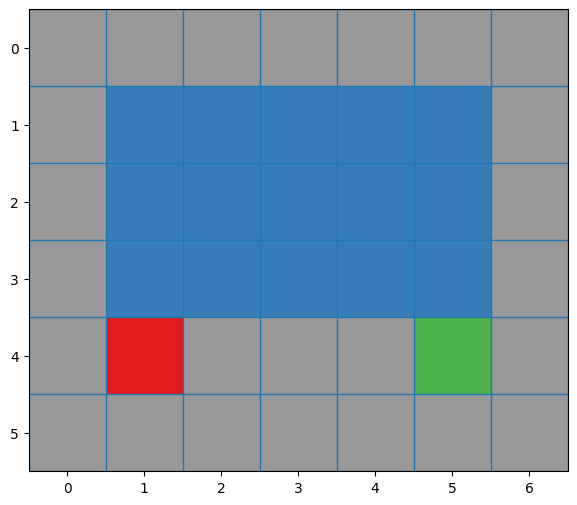

In [2]:
plot_world()

The agent starts in the bottom left corner (red cell) and it needs to reach the safe zone at the bottom right corner (green cell). At every time step the agent can move `up`, `down`, `left`, or `right`. If the agent falls off the cliff (gray cells) then it dies and gets a reward of -100. When it reaches the safe zone it gets a reward of +1. In all other cases it gets a reward of -1 to incentivize the agent to reach the safe zone as fast as possible. When the agent is dead or when it has reached the safe zone it is in a terminal state. There all movements will end up in the same cell with zero reward.

#### Wind

To make it more interesting there is a strong wind blowing downwards in this world. As a result there is a 20% chance that the agent is blown down one cell during his move. So a move upwards has 20% chance of ending in the same state, and a move right  in state (x:2, y:1) has a 20% chance of ending up in cell (x:3, y:2). This means that moving along the cliff at the bottom is really risky because the agent can be pushed off the cliff by the wind.

#### Interface

The already imported class `GridWorldMDP` is the interface to the environment. It has a number of fields that are of interest.
- `STATES`: A list of all the states of the environment. These are simply the cells of the world numbered from top-left to bottom-right. The state represents the cell where the agent is currently positioned. So state `8` means the agent is positioned in the top-left corner of the blue area in the above image.
- `ACTIONS`: A list of all the actions that are possible. Basically this is `['up', 'right', 'down', 'left']`.
- `REWARDS`: A list of all the possible rewards that can be received from the environment (i.e. `[0, 1, -1, -100]`)

Next to that it also provides the following functions:
- `p(state, action, next_state, reward)`: returns the dynamics of the environment. This function will return the probability of a transition from `state` to `next_state` when `action` is performed and `reward` is returned.
- `A(state)`: Returns the list of actions allows in state `state`.

In other words the `GridWorldMDP` class describes the complete MDP of this environment (similar to the `RabbitMDP` class used in the demo).

## Policy Iteration


<img src="figures/policy_iteration.png" width="50%" align="right"> We are going to implement the Policy Iteration algorithm as described on the right. This algorithm is split into three parts. 

1. Initialization.
2. Policy Evaluation. Where we estimate the *state value function* $v_\pi(s)$ for the current policy.
3. Policy Improvement. Where we update the policy $\pi(s,a)$, so it acts greedy with respect to the *action value function*  $q_\pi(s,a)$.

Recall that the value functions can be written recursively as follows:

$$\begin{align}
q_\pi(s,a) & = \sum_{s^\prime \in S} \sum_{r \in R} {p(s, a, s^\prime, r) (r + \gamma v_\pi(s^\prime))} \\
v_\pi(s) & = \sum_{a \in A} {\pi(s, a) q_\pi(s, a)}
\end{align}$$

This means that we can compute the *action value function* $q_\pi(s,a)$ with a known *state value function* $v_\pi(s)$ and vice versa.

In this exercise we will implement the *state value function* $v_\pi(s)$ using a lookup table with estimated values for all the states.

## Policy Evaluation

In the first part of the algorithm we are going to update the lookup table `v` that contains the estimated values of all the states. For this we are first going to make an implementation of $q_\pi(s,a)$, which we will use to update the table.

$$q_\pi(s,a) = \sum_{s^\prime \in S} \sum_{r \in R} {p(s, a, s^\prime, r) (r + \gamma v_\pi(s^\prime))}$$

The current state value estimates are stored in parameter `v` which is an array that can simply be indexed with a state number to return the estimated value of that state. The `env` parameter is a `GridWorldMDP` intance. You can use `env.STATES` or `env.REWARDS` to get a list of all the states or rewards in the MDP. You can use `env.p()` to get the transition probability.

In [3]:
def compute_action_value(env, state, action, v, gamma):
    q = 0
    ### START CODE ###
    
    # Iterate over all possible next states and rewards and compute the expected return of that transition.
    for next_state in env.STATES:
        for reward in env.REWARDS:
            # compute the value of this transition and add it to q
            q += env.p(state, action, next_state, reward) * (reward + gamma * v[next_state])
    ### END CODE ###
    return q

Now let's see if you implemented this correctly with a quick unit test. If you run the next cell it should result in `-20.8`.

In [4]:
env = GridWorldMDP()
v = np.zeros(len(env.STATES))

compute_action_value(env, 16, env._DOWN, v, 0.9)

-20.8

With `compute_action_value` we can now compute the state values for the current policy.

$$v_\pi(s)  = \sum_{a \in A} {\pi(s, a) q_\pi(s, a)}$$

Again the current state value estimates are stored in parameter `v` and the `env` parameter is an instance of `GridWorldMDP`. You can use `env.ACTIONS` to get a list of all possible actions. The current policy $\pi$ is stored in a 2-dimensional array `pi`. It can be indexed with a state and action pair (e.g. `pi[s, a]`) to get the probability for selecting action `a` in state `s`.

In [5]:
def compute_state_value(env, state, v, pi, gamma):
    ### START CODE ###
    value = 0
    # Iterate over all actions
    for action in env.ACTIONS:
        # Use pi and compute_action_value to compute expected return of this action and add it to value
        value += pi[state, action] * compute_action_value(env, state, action, v, gamma)
    ### START CODE ###
    return value

A small unit test to see if the implementation is correct. If you run this the result should be `-5.95`.

In [6]:
env = GridWorldMDP()
v = np.zeros(len(env.STATES))
pi = np.ones((len(env.STATES), len(env.ACTIONS))) / len(env.ACTIONS)

compute_state_value(env, 16, v, pi, 0.9)

-5.95

It is now time to combine this in the Policy Evaluation loop, which will keep updating the state values until the table converges to a certain accuracy $\theta$ (i.e. `theta`). This is already implemented; you don't have to do anything.

In [7]:
def evaluate_policy(env, v, pi, gamma, theta):
    while True:
        delta = 0
        for s in env.STATES:
            vs_old = v[s]
            v[s] = compute_state_value(env, s, v, pi, gamma)
            delta = max(delta, abs(vs_old - v[s]))
        if delta < theta:
            break

Let's try it for one run. We start with initial state value estimates of 0, and a policy with equal distribution for all actions, which are displayed below.

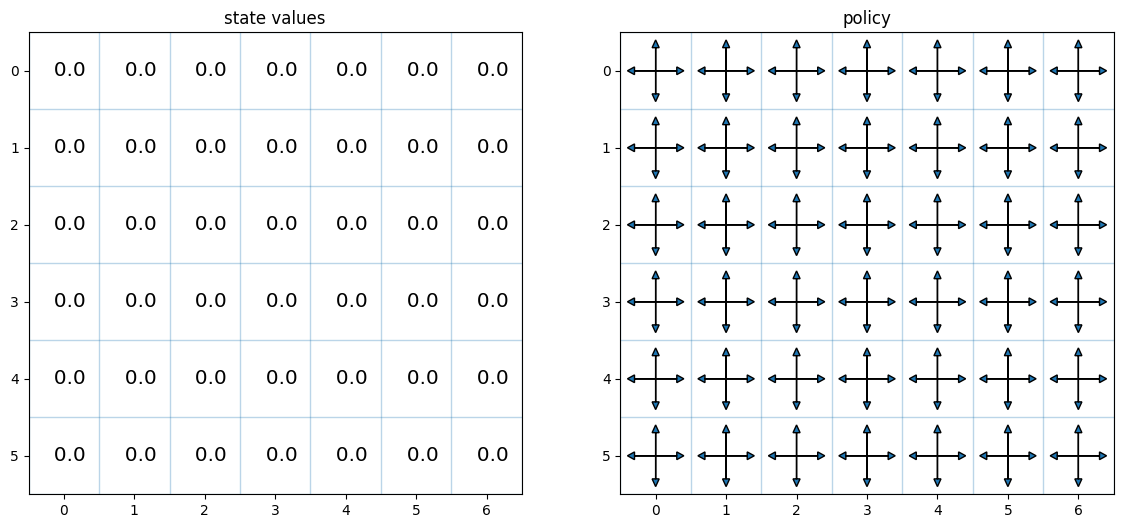

In [8]:
env = GridWorldMDP()
v = np.zeros(len(env.STATES))
pi = np.ones((len(env.STATES), len(env.ACTIONS))) / len(env.ACTIONS)
plot_values_and_policy(v, env, pi)

We can now evaluate this policy to get an updated state value table.

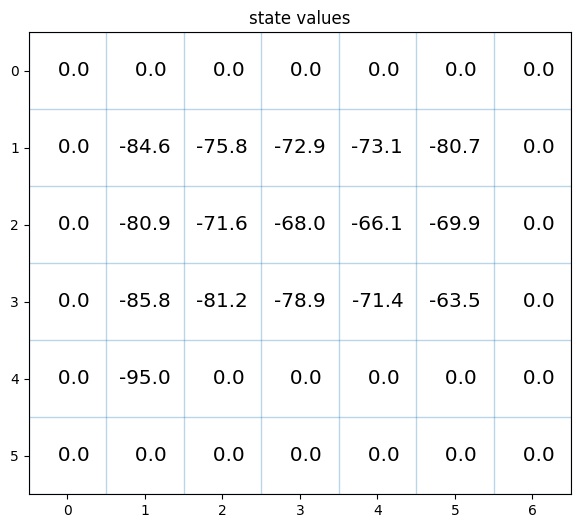

In [9]:
evaluate_policy(env, v, pi, 0.9, 1e-7)

plot_values(v)

## Policy Improvement

Now that the value functions are known for the current policy, we can update the policy so it selects actions that maximum the total reward. This simply means the policy should select actions with the highest action value in the given state (i.e. act greedy with respect to $q_\pi(s,a)$. If more than one action has the highest action value then it should select them with equal probability. For example, if two actions have the highest action value, then the probability for selection each action should be 0.5.

The policy is stored in a two dimensional array `pi`. One row for each state, and a column for each action. We are going to update the policy state by state, so we are going to replace the table row by row.

The function `argmax` is provided to get a list of all actions that have the maximum value a. **Don't use the numpy `argmax` function**, because that only gives the index of the first maximum value, not all of them.

Remember that the sum of all probabilities in a row should be equal to 1.

In [10]:
def greedify_policy(env, v, pi, state, gamma):
    new_pi = np.zeros_like(pi[state])
    
    ### START CODE ###
    
    # Compute the action values for all actions in this state.
    q_s = [compute_action_value(env, state, action, v, gamma) for action in env.ACTIONS]
    
    # Get the list of actions that have the maximum value
    max_actions = argmax(q_s)
    
    # Set the probability for all actions in max_action
    # All these actions should have the same probability and the sum should be 1.
    new_pi[max_actions] = 1 / len(max_actions)
    
    ### END CODE ###
    
    pi[state] = new_pi

Now test to your implementation by running the following cell.

In [11]:
env = GridWorldMDP()
v = np.zeros(len(env.STATES))
pi = np.ones((len(env.STATES), len(env.ACTIONS))) / len(env.ACTIONS)

print(pi[23])
greedify_policy(env, v, pi, 23, 0.9)
print(pi[23])

[0.25 0.25 0.25 0.25]
[0.5 0.  0.  0.5]


In the output you should see the policy for state 23 change from `[0.25 0.25 0.25 0.25]` (i.e. completely random) to `[0.5 0.  0.  0.5]` (only up and left).

We are now ready to implement the full Policy Improvement step, which will greedify the policy for all states and return whether or not it is stable (i.e. didn't change). This is already implemented; you don't have to do anything.

In [12]:
def improve_policy(env, v, pi, gamma):
    is_stable = True
    for state in env.STATES:
        old = pi[state].copy()
        greedify_policy(env, v, pi, state, gamma)
        if not np.array_equal(pi[state], old):
            is_stable = False
    return is_stable

## Policy Iteration

Time to see one iteration through the algorithm in action. We first start with a state value estimates of 0 for all states and a completely random policy. The following cell will display that nicely.

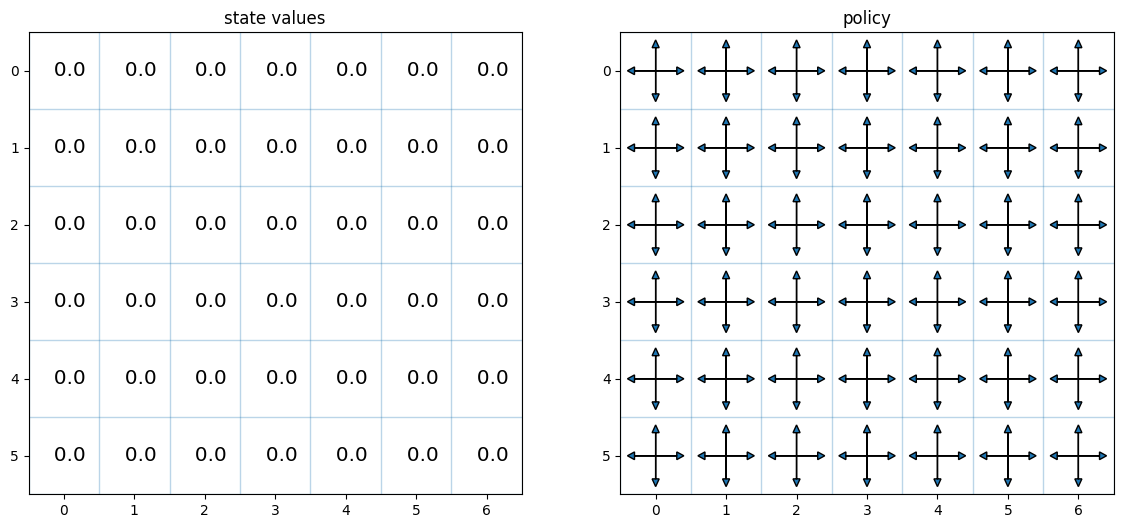

In [13]:
gamma, theta = 0.9, 1e-7

env = GridWorldMDP()
v = np.zeros(len(env.STATES))
pi = np.ones((len(env.STATES), len(env.ACTIONS))) / len(env.ACTIONS)

plot_values_and_policy(v, env, pi)

Then evaluate and improve the policy once and see the result.

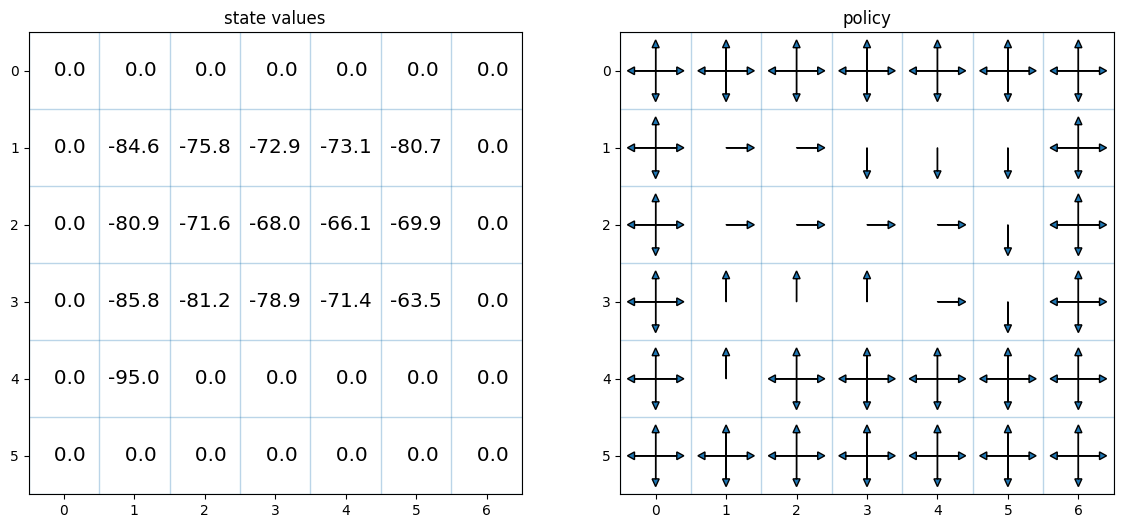

In [14]:
evaluate_policy(env, v, pi, gamma, theta)
is_stable = improve_policy(env, v, pi, gamma)

plot_values_and_policy(v, env, pi)

You should now see that the values for all the 'blue' cells are computed and very negative (< -60). All terminal states (including the end state) should have value 0.

The policy that maximizes the return with these value functions will already walk a route towards the end state. It is not optimal however. For that we have to iterate a few more times.

Alright, this is it. We can now implement the entire algorithm. Fill in the code below and run it to obtain the optimal policy for this grid world. Be patient it can take a while to run.

In [15]:
gamma, theta = 0.9, 1e-7

env = GridWorldMDP()
v = np.zeros(len(env.STATES))
pi = np.ones((len(env.STATES), len(env.ACTIONS))) / len(env.ACTIONS)

is_stable = False
while not is_stable:
    ### START CODE ###
    # Evaluate policy
    evaluate_policy(env, v, pi, gamma, theta)
    # Improve policy and update is_stable accordingly
    is_stable = improve_policy(env, v, pi, gamma)
    ### END CODE ###    

If we now display the resulting value function and policy you can see that the policy has changed a little, in particular in the cells on the right.

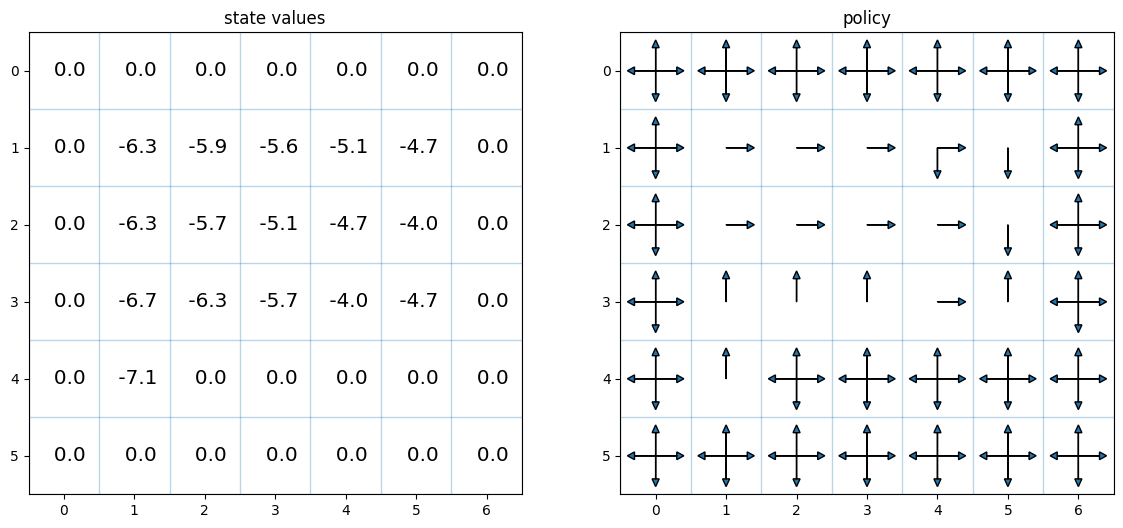

In [16]:
plot_values_and_policy(v, env, pi)

You can see that in cell (x:5, y:3) the direction of the arrow has flipped. This is counter-intuitive. You would think moving down would be the best action, because you are directly above the end goal. However, there is a chance the wind blows you down yet another cell into the cliff. It is safer to move up and then down again with a chance you move down two cells right on the end cell.

This can be seen in the action values for that that state. (Note: actions are order `up`, `right`, `down`, `left`)

In [17]:
state = 3*7+5
qs = [compute_action_value(env, state, action, v, gamma) for action in env.ACTIONS]
print(f'q({state}) = {qs}')

q(26) = [-4.748010610080134, -100.0, -19.2, -23.6933687002657]


The output should be equal to:

    q(26) = [-4.748010610080134, -100.0, -19.2, -23.6933687002657]

This means that going up will result in an expected return of -4.7 and going down in -19.2, which is clearly worse than going up.

## Conclusion

That's it for this exercise. You now understand how to estimate the value functions for a given policy, and how to define a policy given those value functions.

This all depends on a complete understanding of the dynamics of the environment, i.e. a model, in the next exercise we will implement an agent that does not rely on a model and simply learns an optimal policy by interacting with the environment. A model-free algorithm.